In [1]:
import pandas as pd
from enum import Enum
import numpy as np
from matplotlib import pyplot as plt
from cycler import cycler
from typing import List, Dict


In [2]:
from wtn_mdt import data_loader
from wtn_mdt.one_cut import CutScanModel, CutDirection
from wtn_mdt.visualization import setup_style, visualize_classifier_performance_comparison
from wtn_mdt.classifiers import create_all_classifier
import wtn_mdt as wm

In [3]:
setup_style()

# Load The Data

In [4]:
f_name = data_loader.data_path('WTN_data.xlsx')
df = pd.read_excel(f_name)
df['log_RT'] = np.log(df.RT)
features = df[['GR', 'log_RT', 'DEN', 'NPHI']]
xclass = df['Category_actual'].map(lambda x: 1 if x=='Normal' else 0)

all_yes_bench_mark = xclass.sum() / len(xclass)

# Separate Train and Test
using data from excel

In [5]:
# separate train test
well_analysis = pd.read_excel(f_name, sheet_name="well_analysis_copy")
test_marker_dict = {
    row.WellID: row.group_train == 'x' for row in well_analysis.itertuples()
}
use_as_test = df.WellID.map(test_marker_dict)
use_as_train = ~use_as_test

In [6]:
test_features = features[use_as_test]
test_classes = xclass[use_as_test]
test_sample = wm.feature_xclass.FeatureXClass(xclass=test_classes, features=test_features)
train_features = features[use_as_train]
train_classes = xclass[use_as_train]
train_sample = wm.feature_xclass.FeatureXClass(xclass=train_classes, features=train_features)
print(len(test_features), len(train_classes), len(xclass))

1346 722 2068


# All the Classifiers

In [7]:
classifiers = create_all_classifier()

## Train Them

In [8]:
for clf_name, clf in classifiers.items():
    clf.fit(train_features, train_classes) # could do better with out outlier since we have some logistic there

# Test Data Performances

({'logit_log_RT': <<class 'wtn_mdt.perf.AccPerfResult'> logit_log_RT, best_acc=0.7734026745913819, best_cut=0.3908054167518164>,
  'logit_DEN': <<class 'wtn_mdt.perf.AccPerfResult'> logit_DEN, best_acc=0.8610698365527489, best_cut=0.3949120038658791>,
  'logit_GR': <<class 'wtn_mdt.perf.AccPerfResult'> logit_GR, best_acc=0.8060921248142645, best_cut=0.5816347537589791>,
  'logit_NPHI': <<class 'wtn_mdt.perf.AccPerfResult'> logit_NPHI, best_acc=0.787518573551263, best_cut=0.7915429029488674>,
  'one_tree': <<class 'wtn_mdt.perf.AccPerfResult'> one_tree, best_acc=0.8521545319465081, best_cut=0.3>,
  'random_forest': <<class 'wtn_mdt.perf.AccPerfResult'> random_forest, best_acc=0.8551263001485884, best_cut=0.6001379451474399>,
  'logit_no_penalty': <<class 'wtn_mdt.perf.AccPerfResult'> logit_no_penalty, best_acc=0.8588410104011887, best_cut=0.5501502787248417>,
  'logit_default': <<class 'wtn_mdt.perf.AccPerfResult'> logit_default, best_acc=0.8469539375928677, best_cut=0.5423161982740712>

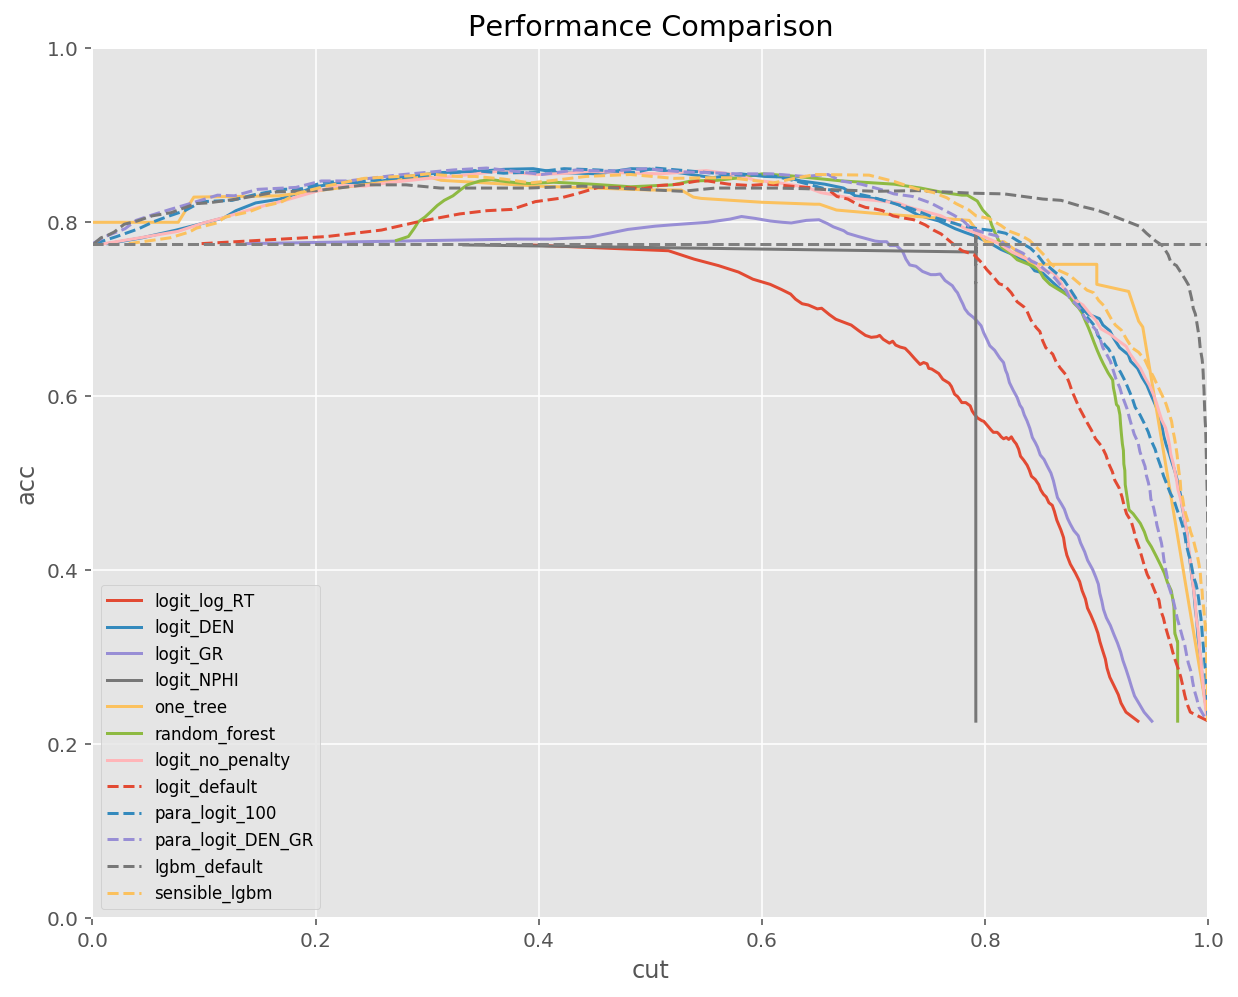

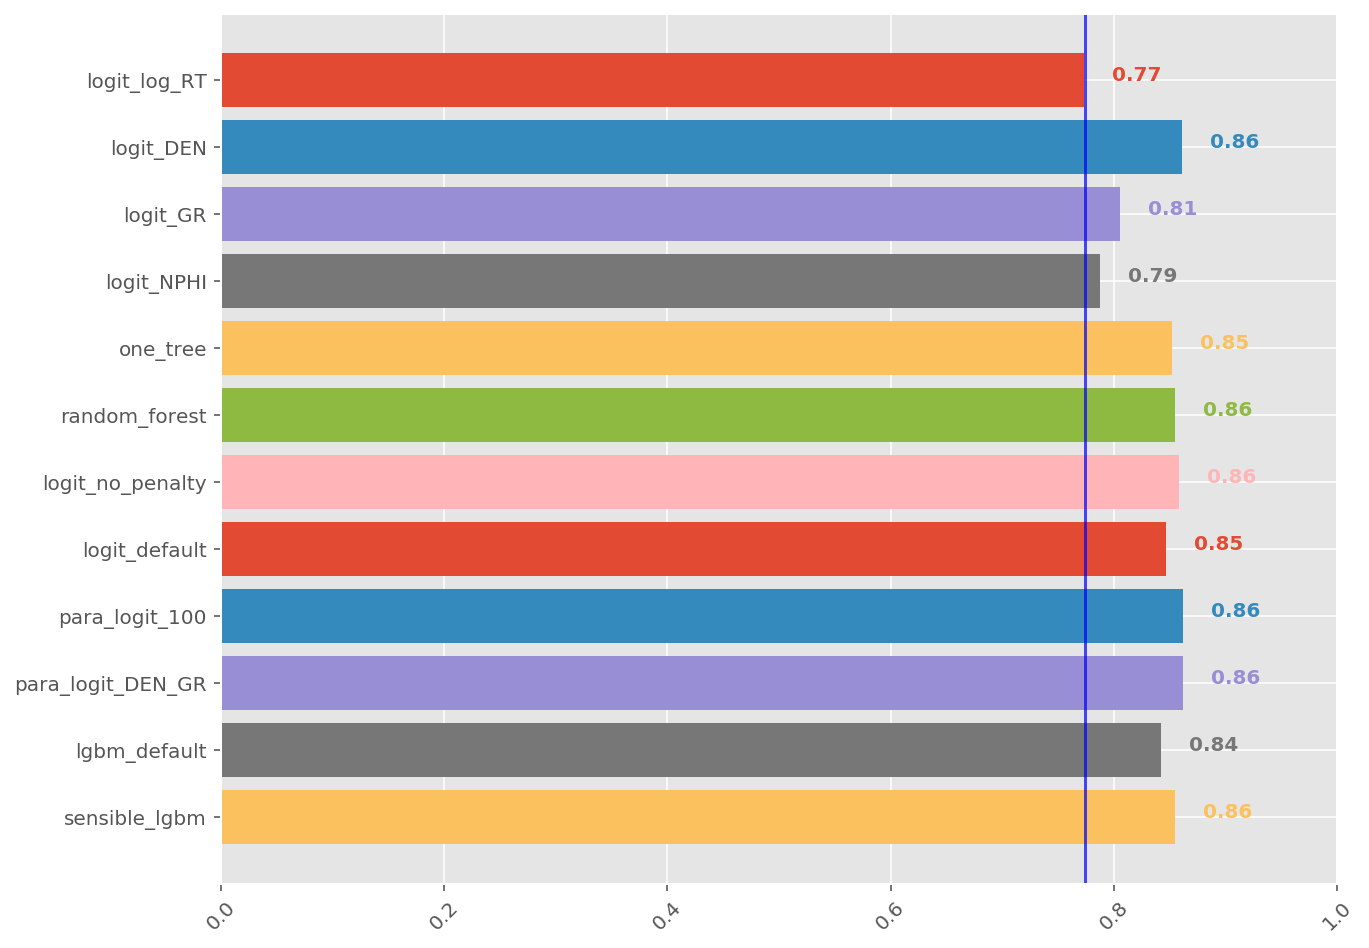

In [9]:
#test data performance
visualize_classifier_performance_comparison(classifiers, test_sample)

# Train Data Performances

Just to make sure we don't overfit like crazy. Well as expect default lgbm will overfit like crazy.

({'logit_log_RT': <<class 'wtn_mdt.perf.AccPerfResult'> logit_log_RT, best_acc=0.7825484764542936, best_cut=0.4481772156544641>,
  'logit_DEN': <<class 'wtn_mdt.perf.AccPerfResult'> logit_DEN, best_acc=0.8601108033240997, best_cut=0.49086474791746604>,
  'logit_GR': <<class 'wtn_mdt.perf.AccPerfResult'> logit_GR, best_acc=0.7894736842105263, best_cut=0.37573078659335946>,
  'logit_NPHI': <<class 'wtn_mdt.perf.AccPerfResult'> logit_NPHI, best_acc=0.8060941828254847, best_cut=0.7915343594346673>,
  'one_tree': <<class 'wtn_mdt.perf.AccPerfResult'> one_tree, best_acc=0.8947368421052632, best_cut=0.4>,
  'random_forest': <<class 'wtn_mdt.perf.AccPerfResult'> random_forest, best_acc=0.8781163434903048, best_cut=0.4311635600500671>,
  'logit_no_penalty': <<class 'wtn_mdt.perf.AccPerfResult'> logit_no_penalty, best_acc=0.8614958448753463, best_cut=0.5339779329110876>,
  'logit_default': <<class 'wtn_mdt.perf.AccPerfResult'> logit_default, best_acc=0.8379501385041551, best_cut=0.60073690947537

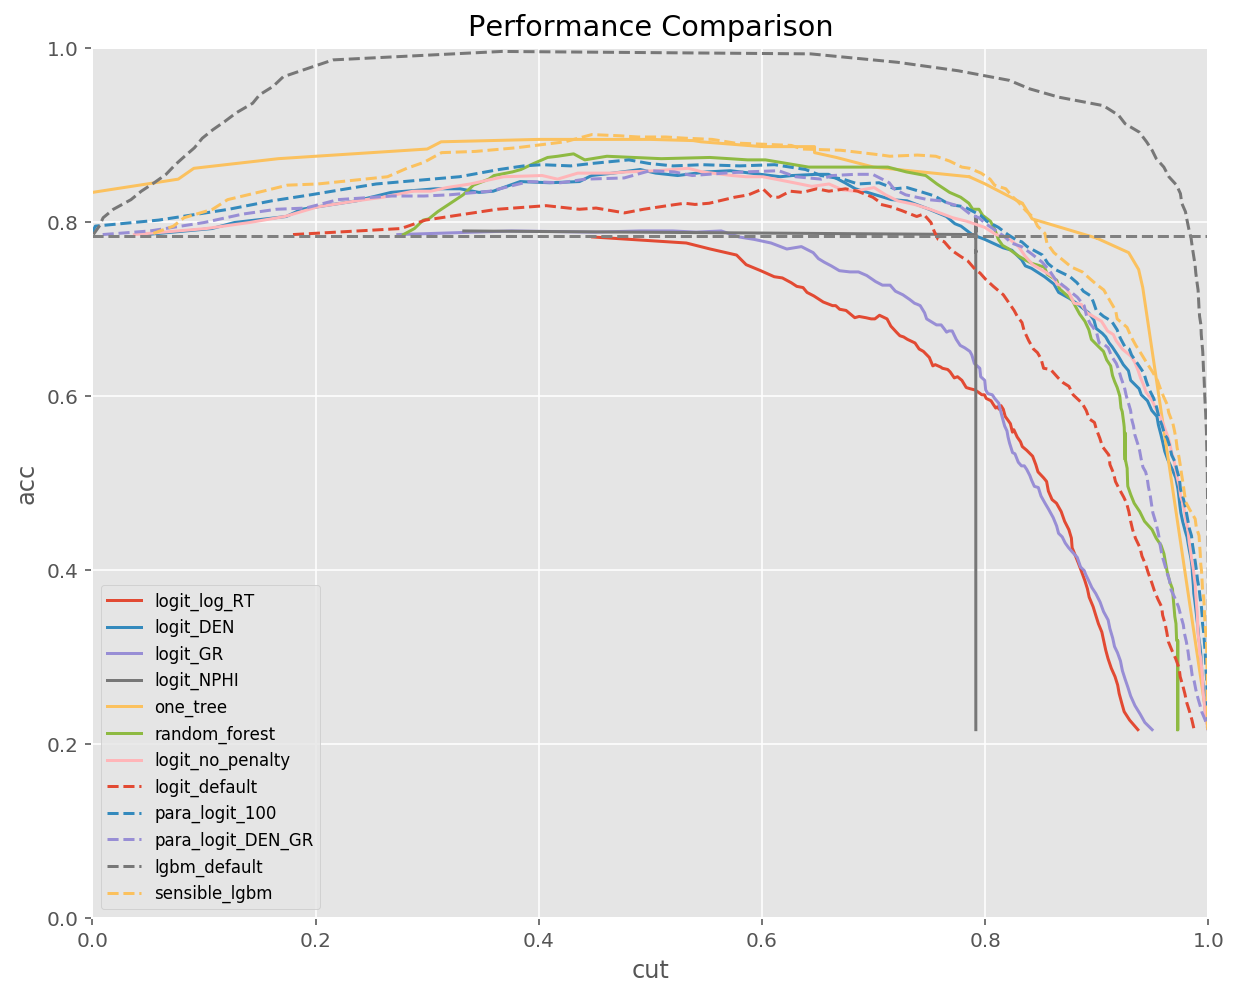

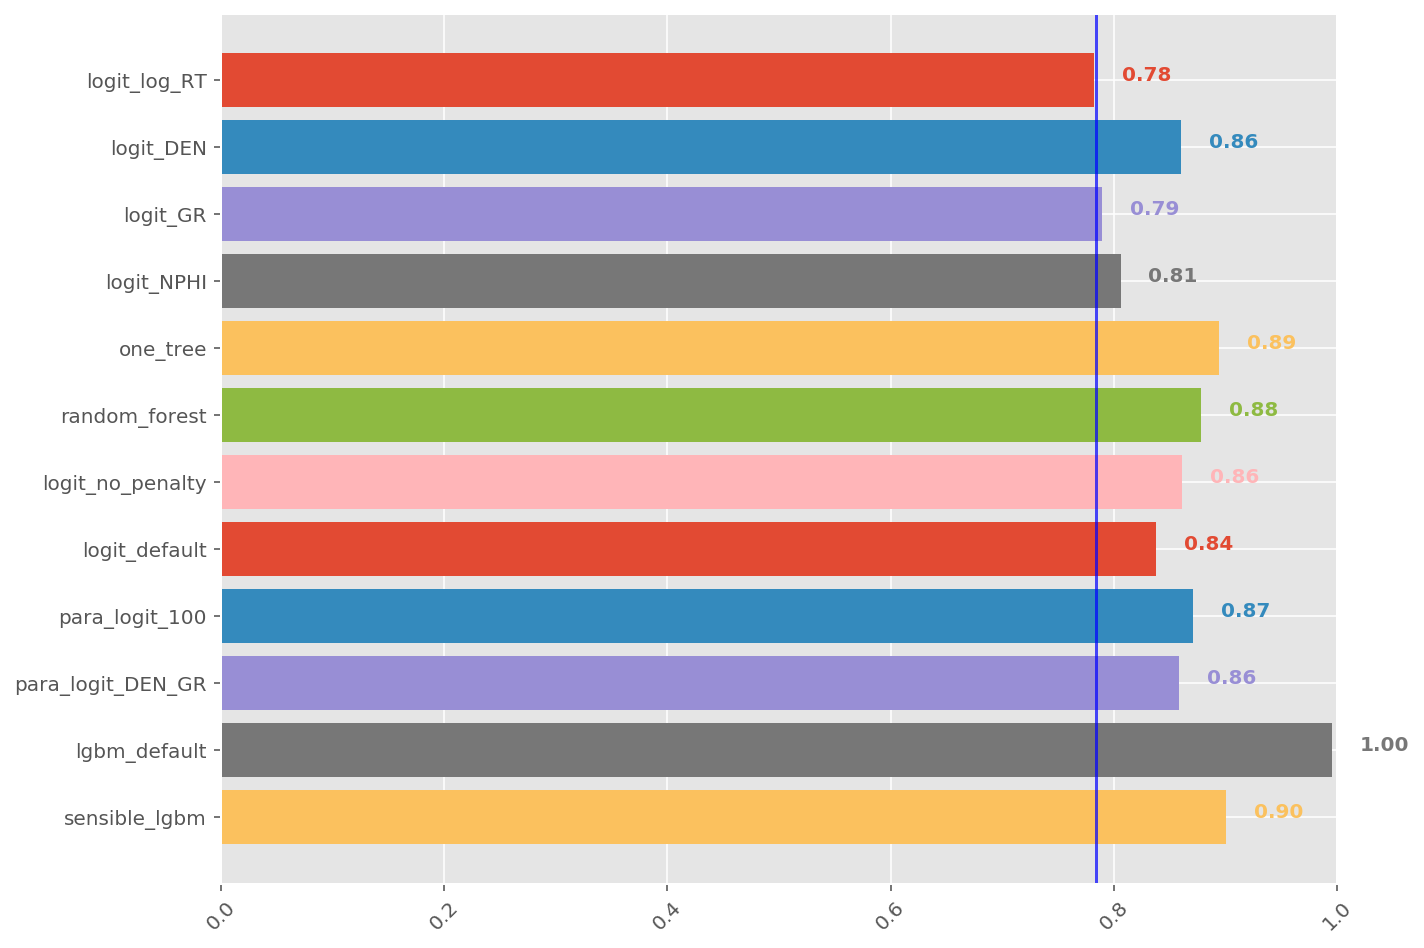

In [10]:
visualize_classifier_performance_comparison(classifiers, train_sample)

# Side note

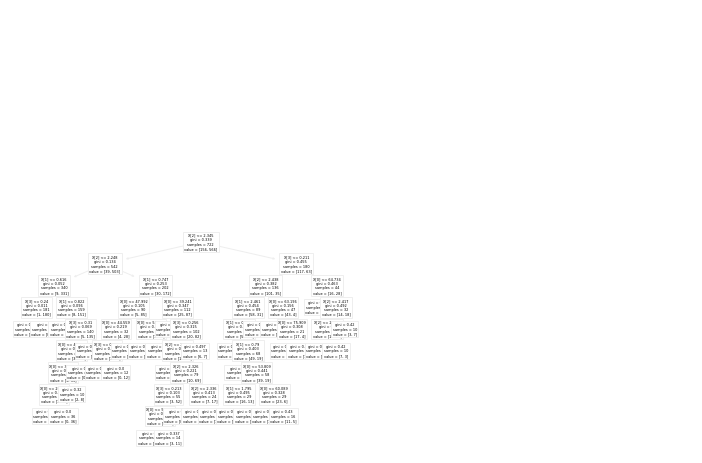

In [11]:
from sklearn import tree
tree.plot_tree(classifiers['one_tree'])
plt.savefig('tree.pdf', bbox_inches='tight')
# yep as expect it cuts at about the 0.2385(max one cut for density)
#!open tree.pdf